In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from copy import copy
from PIL import Image
from tqdm import tqdm
import warnings
from pathlib import Path
import torchvision
import re
import os
from google.colab import drive, files

# mount drive
drive.mount('/content/drive') 

warnings.filterwarnings('ignore')

Mounted at /content/drive


In [2]:
# do not install dependencies as of now
# !pip install tensorboard
# !pip install tf-nightly
# !pip install --upgrade grpcio

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}.".format(device))

Using cuda.


In [ ]:
!mkdir train_local
!unzip '/content/drive/MyDrive/cs160/data/dataset-original.zip' -d 'train_local'

In [5]:
data_path = '/content/train_local/dataset-original'
Path('/content/drive/MyDrive/cs160').mkdir(parents=False, exist_ok=True)

In [6]:
#convert to .png
for file in Path(data_path).glob('**/*.jpg'):
    file.rename(file.with_suffix('.png'))

In [7]:
train_transform = transforms.Compose([
                                      transforms.Resize((512, 512)),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(360, fill=255),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          mean=(0.6727, 0.6401, 0.6046),
                                          std=(0.2093, 0.2103, 0.2317)),
                                     ])

val_transform = transforms.Compose([
                                    transforms.Resize((512, 512)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=(0.6727, 0.6401, 0.6046),
                                        std=(0.2093, 0.2103, 0.2317)),
                                     ])

seed = torch.Generator().manual_seed(0)
dataset = datasets.ImageFolder(root=data_path)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [2022, 505],
                                                           generator=seed)
val_dataset.dataset = copy(dataset)


train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [8]:
iter_sample = iter(DataLoader(dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True))
                        
view_img = [next(iter_sample) for _ in range(4)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


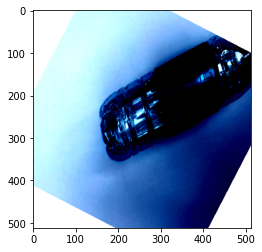

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


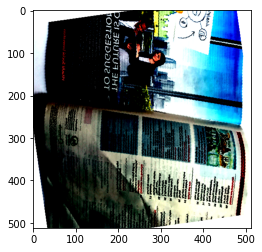

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


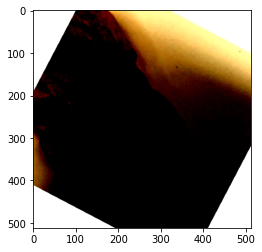

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


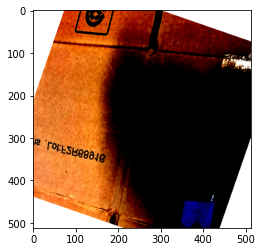

In [9]:
fig = plt.figure()

#images are normalized here
for x, idx in view_img:
    plt.imshow(x.squeeze(0).permute((1, 2, 0)))
    plt.show()

In [10]:
# get mean and standard deviation  
# a = torch.empty((2527, 3, 512, 512), dtype=torch.float)
# for i in range(len(dataset)):
#     a[i] = dataset[i][0]
#     print(i)
# m = a.mean(dim=(0, 2, 3))
# st = a.std(dim=(0, 2, 3))
# data_mean = [0.6727, 0.6401, 0.6046]
# data_std = [0.2093, 0.2103, 0.2317]

In [11]:
class RecycleNet(nn.Module):
    def __init__(self, num_classes=6):
        super(RecycleNet, self).__init__()
        pretrained = torchvision.models.resnet152(pretrained=True)
        for layer in list(pretrained.children()):
            layer.requires_grad = False
        self.model = nn.Sequential(*list(pretrained.children())[:-1])
        self.classifier = nn.Sequential(nn.LazyLinear(4096, bias=True),
                                        nn.ReLU(),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Linear(4096, num_classes))
        self.classifier.requires_grad = True

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x.flatten(1, -1))
        return x

In [12]:
lr = 1e-5
batch_size = 12
num_epoch = 8

model = RecycleNet().to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          num_workers = 8,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_dataset,
                        batch_size=1,
                        num_workers = 2,
                        shuffle=True,
                        pin_memory=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


In [13]:
# log = SummaryWriter()

model.train()
for epoch in range(num_epoch):
  correct = 0
  total_loss = 0
  optimizer.zero_grad()
  tq = tqdm(train_loader, position=0, leave=True)
  tq.set_description("Epoch {}".format(epoch))
  for id, (img, target) in enumerate(tq, 0):
      img, target = img.to(device), target.to(device)
      output = model(img)
      loss = loss_fn(output, target)
      preds = output.argmax(dim=1)
      correct += (preds == target).sum().item()
      total_loss += loss.item()
      acc = correct / (batch_size * (id + 1))
      # log.add_scalar('Loss/train', loss, epoch)
      # log.add_scalar('Accuracy/train', acc, epoch)
      loss.backward()
      optimizer.step()
      tq.set_postfix(loss=total_loss, accuracy=acc)
  torch.save({'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': total_loss,
              'accuracy' : acc
              }, '/content/drive/MyDrive/cs160/RecycleNet.pth')
# log.flush()
# log.close()

Epoch 7: 100%|██████████| 169/169 [03:14<00:00,  1.15s/it, accuracy=0.73, loss=143]


In [14]:
model.load_state_dict(torch.load('/content/drive/MyDrive/cs160/RecycleNet.pth')['model_state_dict'])

correct = 0
total_loss = 0
tq = tqdm(val_loader, position=0, leave=True)

model.eval()
for id, (img, target) in enumerate(tq):
  img, target = img.to(device), target.to(device)
  output = model(img)
  loss = loss_fn(output, target)
  preds = output.argmax(dim=1)
  correct += (preds == target).sum().item()
  total_loss += loss.item()
  acc = correct / (id + 1)
  # log.add_scalar('Loss/val', loss, id)
  # log.add_scalar('Accuracy/val', acc, id)
  tq.set_postfix(loss=total_loss, accuracy=acc)
# log.flush()
# log.close()

100%|██████████| 505/505 [01:01<00:00,  8.23it/s, accuracy=0.707, loss=589]


In [34]:
# tensorboard
# %load_ext tensorboard
# %tensorboard --logdir=runs